# Сравнение скорости архетектур сетевого файлообмена
Мой проект по распределенному файлообмену в сети - <a href="https://github.com/funcid/peas-cli">Peas CLI</a>, для его оценки работы, я хочу рассмотреть идеальный сценарий файлообменов с помощью компьютерного моделирования.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Моделирование систем
Построим собственную модель исходя и принципов Peas и проверим ее на идеальных примерах чтобы получить закономерность. 

In [2]:
file_size = 1 << 8 # размер раздаваемого файла
file = np.arange(file_size) 
partition_size = 1 # размер одной партиции

In [3]:
class ClientServer:
    def __init__(self, id, partitions, clients, tcp_speed):
        self.id = id
        self.partitions = partitions
        self.clients = clients
        self.tcp_speed = tcp_speed
        self.tcp_speed_copy = tcp_speed
    
    def is_downloaded(self):
        return file_size <= len(self.partitions)
    
    def __str__(self):
        return f'N{self.id}: {len(self.partitions) / file_size * 100}%'
    
    def exchange(self, server):
        self.partitions.append(len(self.partitions))
        server.tcp_speed_copy -= partition_size
        self.tcp_speed_copy -= partition_size

In [4]:
def download_partition_decentralized(client):
    for server in client.clients:
        # сами у себя партиции не берем
        if server == client or server.tcp_speed_copy < partition_size or client.tcp_speed_copy < partition_size:
            continue
        # берем только с тех серверов, на которых есть недостающие партиции
        if len(server.partitions) < len(client.partitions):
            continue
            
        client.exchange(server)

def download_partition_centralized(client):
    for server in client.clients:
        if server == client or server.tcp_speed_copy < partition_size or client.tcp_speed_copy < partition_size:
            continue
            
        # этот клиент не может скачивать, пока не истратит сеть предыдущий
        prev = client.clients.index(client) - 1
        if prev > 0 and not client.clients[prev].is_downloaded():
            break
        
        client.exchange(server)
        return True
        
def do_step(nodes, linear):
    
    for server in nodes:
        server.tcp_speed_copy = server.tcp_speed
    
    for client in nodes:
        if client.is_downloaded():
            continue
        
        # нужно скачивать партиции и серверов раздачи
        if linear:
            download_partition_centralized(client)
        else:
            if download_partition_decentralized(client):
                break

def prepare(peas_count, tcp_speed):
    
    empty_clients = []
    for i in range(peas_count - 1):
        empty_clients.append(ClientServer(i, [], [], tcp_speed))
        
    nodes = [
        ClientServer(peas_count, file, [], tcp_speed),
        *empty_clients
    ]
    
    for multicast in nodes:
        multicast.clients = nodes
    
    return nodes
        
def simulate(peas_count, tcp_speed, linear, debug = False):

    nodes = prepare(peas_count, tcp_speed)
    
    operation_count = 0
    
    while not all(x.is_downloaded() for x in nodes):
        operation_count += 1
        do_step(nodes, linear)
        
        if debug and operation_count % 1000 == 0:
            for server in nodes:
                print(server)
    
    if debug:
        for server in nodes:
            print(server)
        
    return operation_count

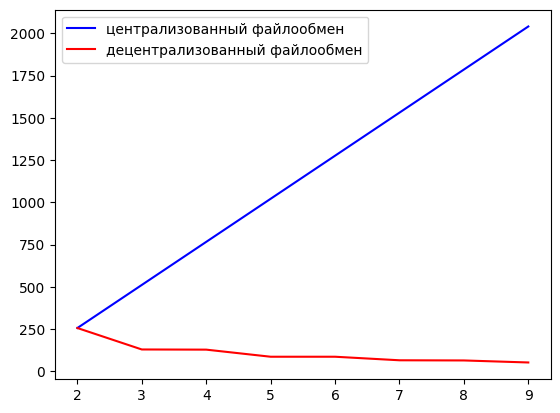

In [5]:
values = np.arange(2, 10)

plt.plot(values, list(map(lambda x: simulate(x, 100, True), values)), color = 'blue', label = 'централизованный файлообмен')
plt.plot(values, list(map(lambda x: simulate(x, 100, False), values)), color = 'red', label = 'децентрализованный файлообмен')
plt.legend()
plt.show()

## Сравнение
Мы видим следующую картину, централизованная раздача имеет линейную функцию, а децентрализованный файлообмен имеет экспоненциальную, при росте числа участников сети, тем больше разница в общей производительности между видами раздачи.

<strong>Централизованная архитектура файлообмена (линейная) -</strong>

$T = \frac{S*N}{V}$, где $T$ - время загрузки, $S$ - размер файла, $V$ - пропускная способность сети, $N$ - количество участников сети без оригинального сервера - источника

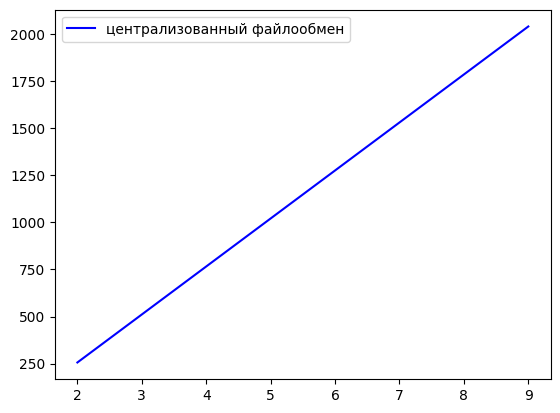

In [6]:
values = np.arange(2, 10)

plt.plot(values, list(map(lambda x: simulate(x, 100, True), values)), color = 'blue', label = 'централизованный файлообмен')
plt.legend()
plt.show()

<strong>Децентрализованная архитектура файлообмена (параллельная) -</strong>

$T = \frac{S}{V*N}$

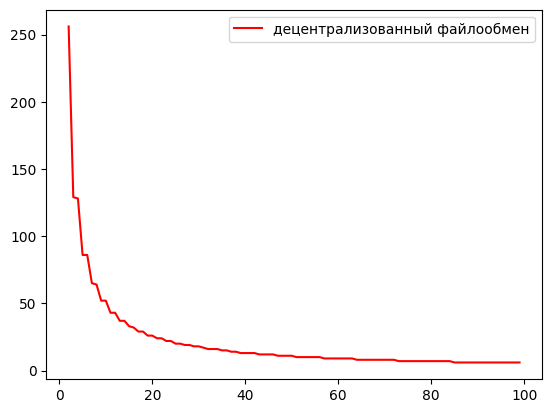

In [7]:
values = np.arange(2, 100)

plt.plot(values, list(map(lambda x: simulate(x, 100, False), values)), color = 'red', label = 'децентрализованный файлообмен')
plt.legend()
plt.show()

## Вывод

Нужные мне закономерности получены и обработы, это сильно поможет при оценке PeasCLI. Между прочим, у каждой из архитектур есть свои плюсы и минусы, параллельный файлообмен гораздо быстрее, однако каждый участник сети будет знать IP-адресс другого. Любой из этих вариантов нужно правильно подбирать под требования задачи.